In [1]:
import numpy as np
import pandas as pd 
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import tensorflow as tf
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, basename
from PIL import Image
from tensorflow.keras.utils import Sequence
from imgaug import augmenters as iaa
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import  Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
print(os.listdir("../input"))

['leafdataset', '2tpk-256-dataset', '2ptk-dataset', '631dataset', 'fixed-leaf']


# **Create Train - Valid - Test Data**

In [2]:
list_train_filenames = glob.glob('../input/leafdataset/2TPK_256/trn/*/*.jpg')
list_train_images1 = [np.array(Image.open(filename)) for filename in list_train_filenames]

list_valid_filenames = glob.glob('../input/leafdataset/2TPK_256/val/*/*.jpg')
list_valid_images1 = [np.array(Image.open(filename)) for filename in list_valid_filenames]

list_labels_train1 = [int(basename(dirname(filename))) for filename in list_train_filenames]
list_labels_valid1 = [int(basename(dirname(filename))) for filename in list_valid_filenames]

*Shuffe data*

In [3]:
train = list(zip(list_train_images1,list_labels_train1))
valid = list(zip(list_valid_images1,list_labels_valid1))

random.shuffle(train)
list_train_images = []
list_labels_train = []
for val in train :
    list_train_images.append(val[0])
    list_labels_train.append(val[1])
    
random.shuffle(valid)
list_valid_images = []
list_labels_valid = []
for val in valid :
    list_valid_images.append(val[0])
    list_labels_valid.append(val[1])

In [ ]:
[int(val) for val in list_labels_train]

In [ ]:
plt.imshow(list_train_images[3])
plt.title(list_labels_train[3])

In [4]:
x_train = np.stack(list_train_images)
y_train = np.stack(list_labels_train)
x_valid = np.stack(list_valid_images)
y_valid = np.stack(list_labels_valid)

# Data Augumentation
* Nhân 8 lần lượng samples của train set dựa trên các phép biến đổi ảnh

In [84]:
class DataGenerator(Sequence):
    """
    Data Generator for Image
    """
    def __init__(self, batch_size, np_images, np_labels):
        self.batch_size = batch_size
        self.np_labels = np_labels
        self.np_images = np_images

        self.num_images = len(self.np_images)
        
        self.preprocesser = iaa.Sequential(
             [
              iaa.Rot90((1,3)),
                 iaa.AdditiveGaussianNoise(scale=0.1*255),
                 iaa.Sharpen(alpha=0.5)
             ],
#             random_order= True
        )
        self.preprocesser_1 = iaa.Sequential(
              [
                  
                 iaa.Rot90((1,3)),
                  iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6)),
              ],
#             random_order= True
        )
        self.preprocesser_2 = iaa.Sequential(
              [
                 iaa.Rot90(1),
                  iaa.LogContrast(gain=(0.6, 1.4))
              ],
#             random_order= True
        )
        self.preprocesser_3 = iaa.Sequential(
              [
                 iaa.Rot90(1),
                  iaa.GammaContrast((0.5, 2.0))
              ],
#             random_order= True
        )
        
        self.preprocesser_4 = iaa.Sequential(
              [
                 iaa.Fliplr(0.5),
              ],
#             random_order= True
        )
        self.preprocesser_5 = iaa.Sequential(
              [
                iaa.Fliplr(0.5),
                  iaa.LogContrast(gain=(0.6, 1.4))
              ],
#             random_order= True
        )
        
        self.preprocesser_6 = iaa.Sequential(
              [
                  iaa.Fliplr(0.5),
                  iaa.GammaContrast((0.5, 2.0))
                  
              ],
#             random_order= True
        )
        self.preprocesser_7 = iaa.Sequential(
              [
                  iaa.Fliplr(0.5),
                  iaa.AdditiveGaussianNoise(scale=0.1*255)
              ],
#             random_order= True
        )
        self.preprocesser_8 = iaa.Sequential(
              [
                 
                   iaa.Fliplr(0.5),
                  iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6)),
              ],
#             random_order= True
        )
        self.preprocesser_9 = iaa.Sequential(
              [
                 iaa.Fliplr(0.5),
                  iaa.Sharpen(alpha=0.5)
              ],
#             random_order= True
        )
        

        self.indices = np.random.permutation(self.num_images)

    def on_epoch_end(self):
        self.indices = np.random.permutation(self.num_images)

    def __len__(self):
        # return len = 46 ~~ Steps per epoch (Iteration)
        # 1 iteration = 1 batchsize 
        # 46 * 128 
        return int(self.num_images / self.batch_size)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size: (index+1) * self.batch_size] # index của 32 tấm/batch
        batch_images = self.np_images[batch_indices] # 32 tấm theo index shuffe
        batch_labels = self.np_labels[batch_indices] # 32 label

        batch_preprocessed_images = self.preprocesser(images = batch_images) # num(batch_size) tấm mới
        batch_preprocessed_images_1 = self.preprocesser_1(images = batch_images) # 32 tấm mới
        batch_preprocessed_images_2 = self.preprocesser_2(images = batch_images) # 32 tấm mới
        batch_preprocessed_images_3 = self.preprocesser_3(images = batch_images) # 32 tấm mới
        batch_preprocessed_images_4 = self.preprocesser_4(images = batch_images) # 32 tấm mới
        batch_preprocessed_images_5 = self.preprocesser_5(images = batch_images) # 32 tấm mới
        batch_preprocessed_images_6 = self.preprocesser_6(images = batch_images) # 32 tấm mới
        batch_preprocessed_images_7 = self.preprocesser_7(images = batch_images) # 32 tấm mới
        batch_preprocessed_images_8 = self.preprocesser_8(images = batch_images) # 32 tấm mới
        batch_preprocessed_images_9 = self.preprocesser_9(images = batch_images) # 32 tấm mới
        
        # Data x2
        data_images_1 = np.concatenate([batch_images, batch_preprocessed_images]) # concat = 32 + 32 images
        data_labels_1 = np.concatenate([batch_labels, batch_labels]) # concat = 32 + 32 labels
        # Data x3
        data_images_2 = np.concatenate([data_images_1, batch_preprocessed_images_1]) # concat = 64 + 32 images
        data_labels_2 = np.concatenate([data_labels_1, batch_labels]) # concat = 64 + 32 
        # Data x4
        data_images_3 = np.concatenate([data_images_2, batch_preprocessed_images_2]) # concat = 96 + 32 images
        data_labels_3 = np.concatenate([data_labels_2, batch_labels]) # concat = 96 + 32 labels
        # Data x5
        data_images_4 = np.concatenate([data_images_3, batch_preprocessed_images_3])
        data_labels_4 = np.concatenate([data_labels_3, batch_labels])
        # Data x6
        data_images_5 = np.concatenate([data_images_4, batch_preprocessed_images_4])
        data_labels_5 = np.concatenate([data_labels_4, batch_labels])
        # Data x7
        data_images_6 = np.concatenate([data_images_5, batch_preprocessed_images_5])
        data_labels_6 = np.concatenate([data_labels_5, batch_labels])
        # Data x8
        data_images_7 = np.concatenate([data_images_6, batch_preprocessed_images_6])
        data_labels_7 = np.concatenate([data_labels_6, batch_labels])
        # Data x9
        data_images_8 = np.concatenate([data_images_7, batch_preprocessed_images_7]) 
        data_labels_8 = np.concatenate([data_labels_7, batch_labels]) 
        # Data x10
        data_images_9 = np.concatenate([data_images_8, batch_preprocessed_images_8]) 
        data_labels_9 = np.concatenate([data_labels_8, batch_labels]) 
        # Data x11
        data_images = np.concatenate([data_images_9, batch_preprocessed_images_9]) # concat = 128 + 32 images
        data_labels = np.concatenate([data_labels_9, batch_labels]) # concat = 128 + 32 labels
        return data_images, data_labels
#         return data_labels

In [6]:
class DataGenerator2(Sequence):
    """
    Data Generator for Image
    """
    def __init__(self, batch_size, np_images, np_labels):
        self.batch_size = batch_size
        self.np_labels = np_labels
        self.np_images = np_images

        self.num_images = len(self.np_images)
        self.indices = np.random.permutation(self.num_images)

    def on_epoch_end(self):
        self.indices = np.random.permutation(self.num_images)

    def __len__(self):
        
        return int(self.num_images / self.batch_size)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size: (index+1) * self.batch_size]
        batch_images = self.np_images[batch_indices]
        batch_labels = self.np_labels[batch_indices]
        
        data_images = batch_images 
        data_labels = batch_labels 
        return data_images, data_labels
#         return data_labels

In [104]:
train_generator = DataGenerator(16, x_train, y_train)
valid_generator = DataGenerator2(50, x_valid, y_valid)

In [105]:
train_generator[1][0].shape

(176, 256, 256, 3)

In [106]:
print(len(train_generator))
print(len(valid_generator))

86
9


# **Modeling**

In [107]:
class LeafClassifier:
    def __init__(self):
        self.model = None

    def build_model(self):
        input_layer = Input(shape = (256, 256, 3))

        conv_layer_1 = (Conv2D(64, kernel_size = 3, strides = 2, padding='same', activation="relu"))(input_layer)
        max_pooling_2d_a = (MaxPooling2D(pool_size=(2, 2)))(conv_layer_1)

        conv_layer_2 = (Conv2D(128, kernel_size = 3, strides = 2, padding='same', activation="relu"))(max_pooling_2d_a)
        max_pooling_2d_b = (MaxPooling2D(pool_size=(2, 2)))(conv_layer_2)
        
        conv_layer_3 = (Conv2D(256, kernel_size = 3, strides = 1,padding='same', activation="relu",kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))(max_pooling_2d_b)
        max_pooling_2d_c = (MaxPooling2D(pool_size=(2, 2)))(conv_layer_3)
        
        conv_layer_4 = (Conv2D(256, kernel_size = 3, strides = 1,padding='same', activation="relu",kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))(max_pooling_2d_c)
        max_pooling_2d_e = (MaxPooling2D(pool_size=(2, 2)))(conv_layer_4)      
          
        flat = Flatten()(max_pooling_2d_e)
    
        dense_layer_1 = Dense(512, activation ='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01))(flat) 
        
        dense_layer_2 = Dense(256, activation ='relu')(dense_layer_1)

        output_layer = Dense(1, activation = 'sigmoid')(dense_layer_2)
        
        # Model Summary 
        self.model = Model(input_layer, output_layer)
        print(self.model.summary())
             
        # Compile
        loss = BinaryCrossentropy()     
        optimizer = Adam(learning_rate=0.001)
        self.model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics= ['accuracy'])
#         self.model.compile(loss = loss, optimizer=optimizer, metrics=[CategoricalAccuracy()])
        
    def save_model(self):   
        pass 

    def load_model(self):
         self.model = load_model('model/leaf2.hdf5')
        
    def train(self, train_generator, valid_generator,**kwargs):
        keras_callbacks   = [
              EarlyStopping(monitor='val_loss', patience=10, mode='min'),
              ModelCheckpoint('model/leaf2.hdf5',monitor = 'val_loss',save_best_only = True, verbose = 1 )
        ]
        self.history = classifier.model.fit(
            train_generator,
            validation_data=valid_generator,
            steps_per_epoch= len(train_generator),
            shuffle = True,
            workers=2,
            epochs=100,
            validation_steps = len(valid_generator),
            callbacks = [keras_callbacks]
        )

    def predict(self, x_test):
        y_predict = self.model.predict(np.array(x_test))
        return y_predict

In [109]:
classifier = LeafClassifier()
classifier.build_model()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 8, 8, 256)         0  

In [110]:
classifier.train(train_generator, valid_generator)

Epoch 1/100
86/86 [==============================] - 28s 316ms/step - loss: 16.8533 - accuracy: 0.5316 - val_loss: 5.8660 - val_accuracy: 0.4711

Epoch 00001: val_loss improved from inf to 5.86600, saving model to model/leaf2.hdf5
Epoch 2/100
86/86 [==============================] - 27s 301ms/step - loss: 5.2694 - accuracy: 0.5860 - val_loss: 4.1507 - val_accuracy: 0.4422

Epoch 00002: val_loss improved from 5.86600 to 4.15071, saving model to model/leaf2.hdf5
Epoch 3/100
86/86 [==============================] - 26s 295ms/step - loss: 3.7827 - accuracy: 0.6558 - val_loss: 3.0599 - val_accuracy: 0.7600

Epoch 00003: val_loss improved from 4.15071 to 3.05991, saving model to model/leaf2.hdf5
Epoch 4/100
86/86 [==============================] - 26s 291ms/step - loss: 2.8716 - accuracy: 0.7601 - val_loss: 2.5417 - val_accuracy: 0.6689

Epoch 00004: val_loss improved from 3.05991 to 2.54169, saving model to model/leaf2.hdf5
Epoch 5/100
86/86 [==============================] - 25s 289ms/step

# **Visualizing**

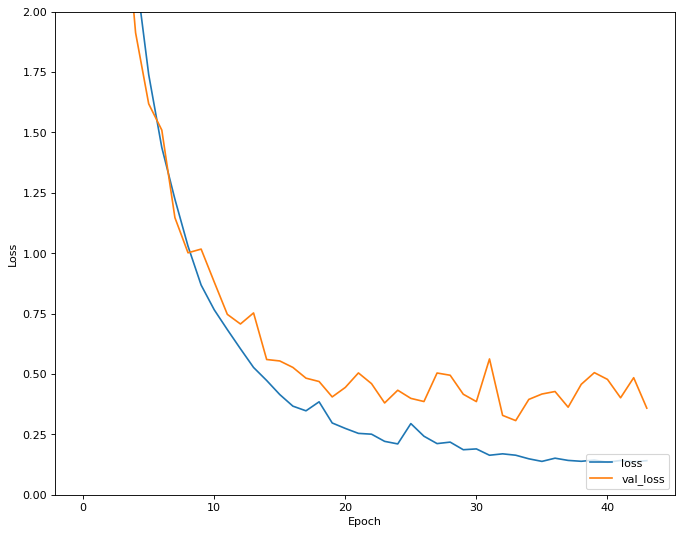

In [111]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)
plt.plot(classifier.history.history['loss'], label='loss')
plt.plot(classifier.history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

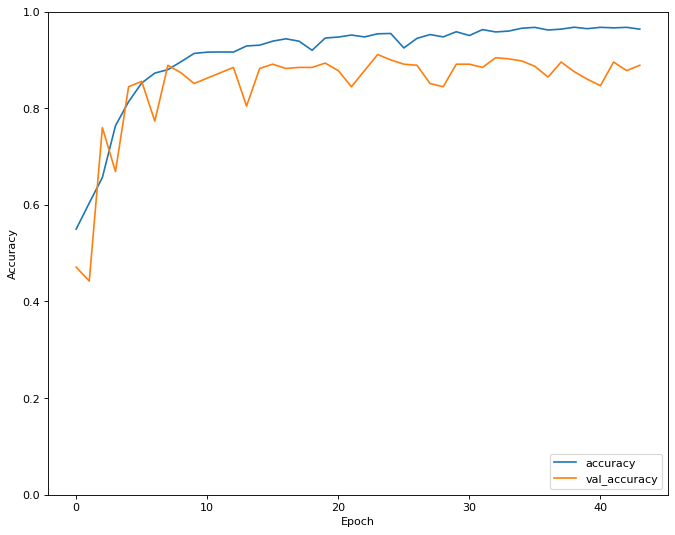

In [112]:
figure(figsize=(10, 8), dpi=80)
plt.plot(classifier.history.history['accuracy'], label='accuracy')
plt.plot(classifier.history.history['val_accuracy'], label = 'val_accuracy')
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label = 'val_loss') 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0 ,1])
plt.legend(loc='lower right')

# **Evaluation**

In [113]:
# classifier = LeafClassifier()
classifier.load_model()
labels_word = { 0 : "lá khỏe",
                1 : "lá bệnh",
              }

In [196]:
test_images = np.array(Image.open('../input/leafdataset/2TPK_256/tst/1/leaf_tst_100016.jpg'))

In [197]:
classifier.model.predict(np.array([test_images]))


array([[0.99999475]], dtype=float32)

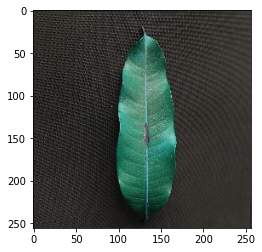

In [198]:
import matplotlib.pyplot as plt
plt.imshow(test_images)

In [116]:
list_test_filenames = glob.glob('../input/leafdataset/2TPK_256/tst/*/*.jpg')
list_test_images = [np.array(Image.open(filename)) for filename in list_test_filenames]
list_labels_test = [int(basename(dirname(filename))) for filename in list_test_filenames]

# print(len(list_test_images))

#fig, axs = plt.subplots(1,5,figsize=(25,10))
predict_lbl = []
for i in range(len(list_test_filenames)):
    img = list_test_images[i]
    img = np.squeeze(img)
    prob = classifier.model.predict(np.array([list_test_images[i]]))
    if prob > .5:
        predict_lbl.append(1)
    else:
        predict_lbl.append(0)
    

In [117]:
from sklearn.metrics import roc_auc_score, accuracy_score
print("ROC-AUC: ", roc_auc_score(list_labels_test,predict_lbl))
print("Accuracy: ", accuracy_score(list_labels_test,predict_lbl))

ROC-AUC:  0.9272258866090516
Accuracy:  0.9273504273504274


In [ ]:
0.8760026310500447
0.8782051282051282

